<a href="https://colab.research.google.com/github/IjeomaM/dotnet-project/blob/main/Copy_of_Lab_04_Convolutional_Neural_Network_Application_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 04 Convolutional Neural Network Application

# 1 Import Packages

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [1]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

# 2 Dataset

## 2.1 Download the Facial Expression Recognition Dataset

In [2]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [3]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/trolukovich/food11-image-dataset/')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ijeomamaduka
Your Kaggle Key: ··········


100%|██████████| 1.08G/1.08G [00:10<00:00, 108MB/s]


## 2.2 PyTorch Dataset and Dataloader

In [4]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for facial expression recognition.
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
# Construct datasets.
train_dataset = datasets.ImageFolder("/content/food11-image-dataset/training", transform=train_transform)
validation_dataset = datasets.ImageFolder("/content/food11-image-dataset/validation", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/food11-image-dataset/evaluation", transform=test_transform)




print(f'Train set has {len(train_dataset)} samples')
print(f'Validation set has {len(validation_dataset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Train set has 9866 samples
Validation set has 3430 samples
Test set has 3347 samples


In [11]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

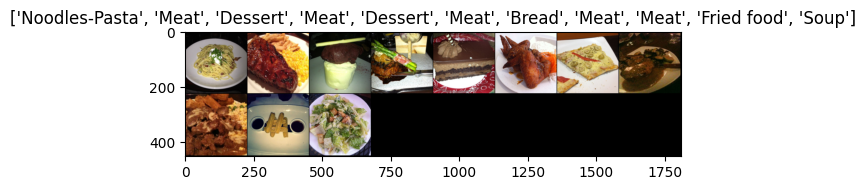

In [12]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_dataset, batch_size=11, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Bread', 'Dairy products', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Seafood', 'Soup', 'Vegetable-Fruit']

imshow(out, title=[class_names[x] for x in classes])

# 3 Model

In [13]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [14]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

# 4 Define Loss and Optimizer

In [15]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# 5 Train and Validation

In [ ]:
# The number of training epochs.
n_epochs = 50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/309 [00:00<?, ?it/s]

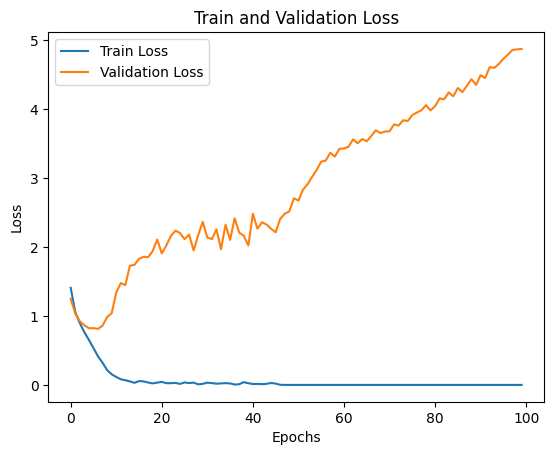

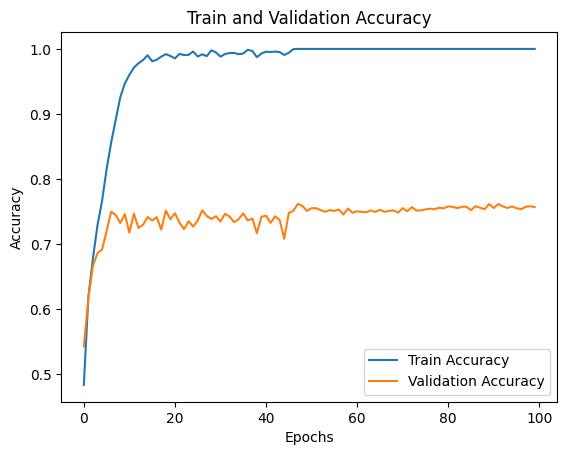

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

From the curve, we can observe the problem of overfitting.

It would be worthy to try regularization techniques, such as dropout. You can also add batchnorm, change the CNN/linear layers (numbers, input/output channels, kernel size, etc.), use well-defined models in torchvision, add data augmentation, etc. You can also try to modify the optimizer. For example, you can reduce the learning rate. There is another way to dynamically change the learning rate during the training - [learning rate scheduling](https://d2l.ai/chapter_optimization/lr-scheduler.html).

In addition, the sample code may not be good enough. You can learn more about PyTorch to enhance it from the coding perspective.

# 6 Testing




Before making test, please make sure you have selected the best model parameters through best validation accuracy.

Idealy, you should only run the following code once in your entire deep learning model development pipeline.

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/96 [00:00<?, ?it/s]

Test accuracy 0.7583240866661072


# 7 Improve Performance

## 7.1 Data Augmentation

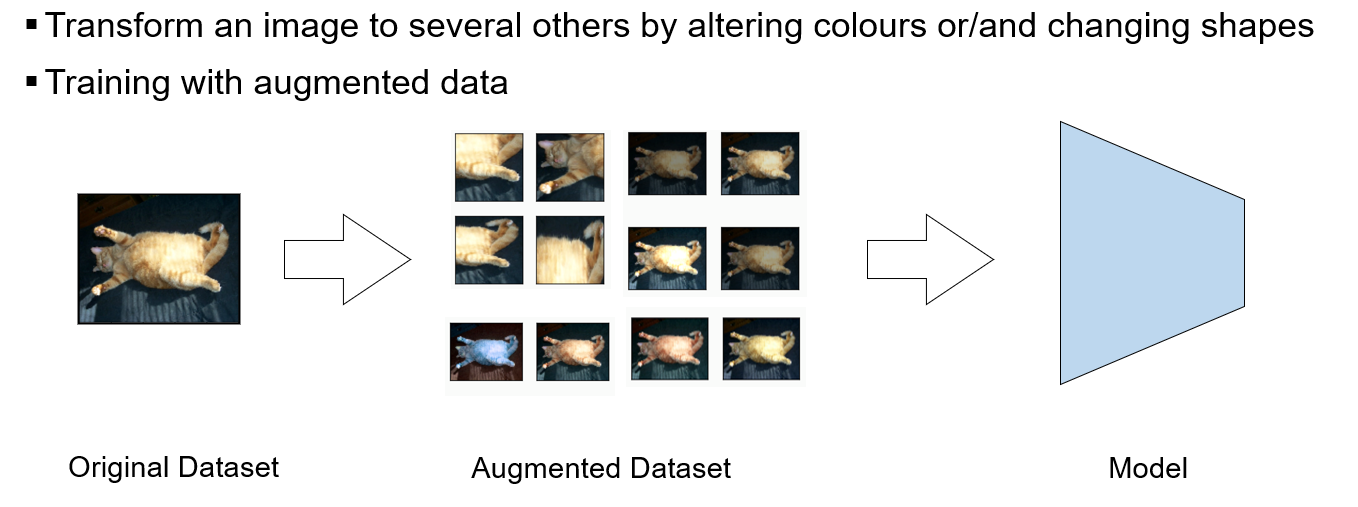

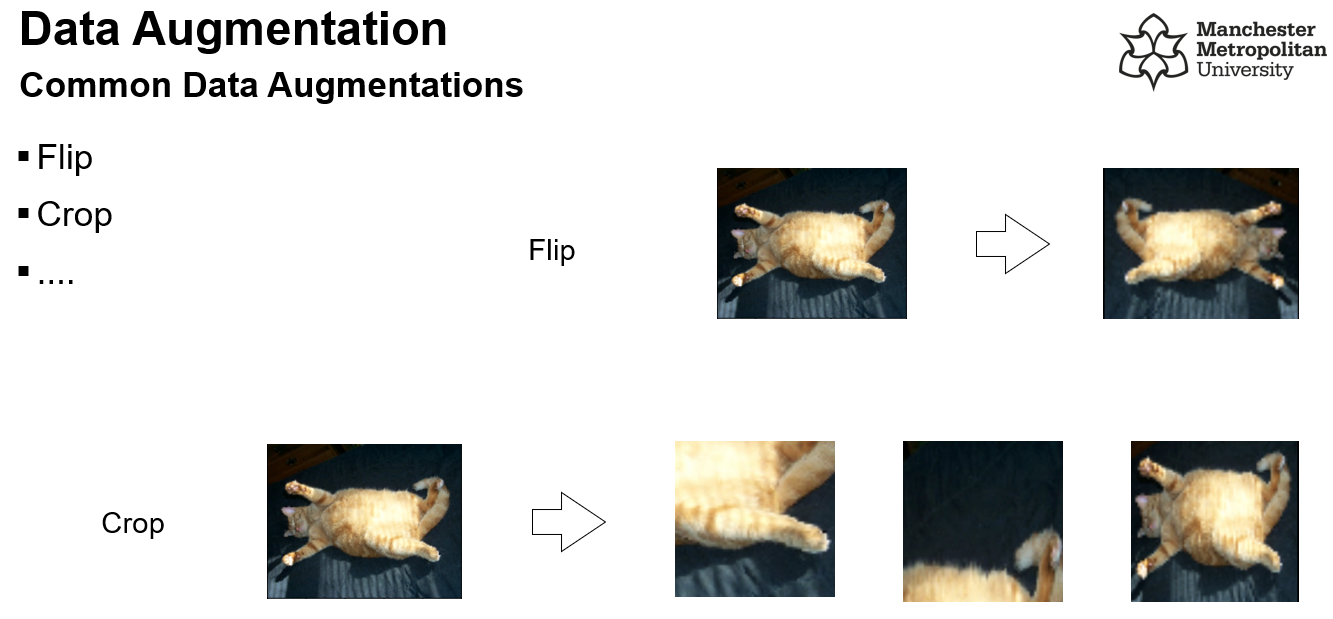

You can use the following part of the code to replace the orginal transformation to apply data augmentation to see if there is an improvement.

```
import torchvision.transforms as transforms

# Define the transformations for data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.RandomRotation(degrees=10),    # Random rotation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # Adjust color
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
```



## 7.2 Use Pretrained Model and Weights


For example, if you use ResNet-18 as your model:

`model = torchvision.models.resnet18(num_classes=7)`

There are more models in [torchvision.models](https://pytorch.org/vision/stable/models.html). You can access AlexNet, DenseNet, GooLeNet, InceptionNet, MobileNet, etc.

You can also load model parameters trained on ImageNet, but you have to manually modify the output number of classes.

`model = torchvision.models.resnet18(pretrained=True)  `


# 8 Hot to use this code for my own project (dataset)?

[Creating a Custom Dataset for your files](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file annotations_file.



```
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
```

`__init__`

The `__init__` function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The labels.csv file looks like:
```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```
```
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
```

`__len__`

The `__len__` function returns the number of samples in our dataset.

Example:
```
def __len__(self):
    return len(self.img_labels)
```

`__getitem__`

The `__getitem__` function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in `self.img_labels`, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.
```
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label
```

More about loading your own datasets:

[Developing Custom PyTorch Dataloaders](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html)

[Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

[Writing Custom Datasets, DataLoaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)


# Ackowledgement

This lab is modified by Xinqi Fan for Deep Learning at Manchester Metropolitan University.

The original jupyter notebook was developed for the Machine Learning course offered by Prof. Hung-yi Lee from Department of Electrical Engineering, National Taiwan University.